## University of Wisconsin at Madison Examination of Grade Distributions 

### Abstract:

Grades at the university level are a reflection of student learning, professor teaching and engagement with the subject. Using a publicly available dataset from the University of Wisconsin, Madison, student grades from 2006 to 2017 were examined to see if there is a difference in grades in STEM or traditional liberal arts classes, large or small classes, morning or afternoon classes and if there was grade inflation over the decade. No significant difference was detected in grade distributions in STEM when compared with traditional liberal arts classes or in morning or afternoon classes. Grade inflation was just barely significant; more study on the topic would be advised in order to reach robust conclusions. However, there is a very real difference in grade distributions in large classes when compared with small ones with small classes having significantly higher grades and more "A"s overall given. 

### The Data Set

The University of Wisconsin at Madison (UW-M) administration is concerned about enrollment, retention and graduation rates. As part of addressing this concern, an examination of grades across all subjects covering the years 2006 - 2017. The goal was to understand four issues: 1. if STEM fields had different grade distributions than traditional liberal arts subjects, 2. Did large classes (more than 35 students, which is the 75th percentile of enrollment) had a different grade distribution than smaller classes, 3. Does the time of day (before or after noon) make a difference in grades, and 4. Has there been a change in grade distributions over the 10 years of the dataset. The assumption is that grades are a proxy for student success and knowledge gained. They also acted as a proxy for enrollment, one grade per student. UW-M publishes reports for all courses (and sections of these courses), instructors, subjects, and grade reports for each section for every Fall and Spring semester since 2006.

There are more than 9,000 courses in this dataset. There are nearly 200,000 course sections with grades, with 3 million grades reported in total. 18,000 instructors are included in the dataset, all of whom are associated with various sections that may or may not have grades reported for them.

The data was retrieved from the UW Madison registrar office, and extracted from PDF files using the open source tool, madgrades-extractor. This information was publicaly available on kaggle. This is the work of Helen Levy-Myers and Llewellyn Hickes Jones.

### Load the data and needed libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv, sqlite3
from scipy.stats import ttest_ind
import random

In [3]:
conn = sqlite3.connect('/Users/flatironschool/BootCamp/Grades_Project/uw-madison-courses/madison.db')

In [4]:
c = conn.cursor()
c.execute("""SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE "sqlite%";""").fetchall()


[('instructors',),
 ('grade_dist',),
 ('courses',),
 ('course_offerings',),
 ('subjects',),
 ('subject_memberships',),
 ('sections',),
 ('schedules',),
 ('rooms',),
 ('focus',),
 ('teachings',),
 ('Term',)]

The database is available on Kaggle. This schema was also provided.

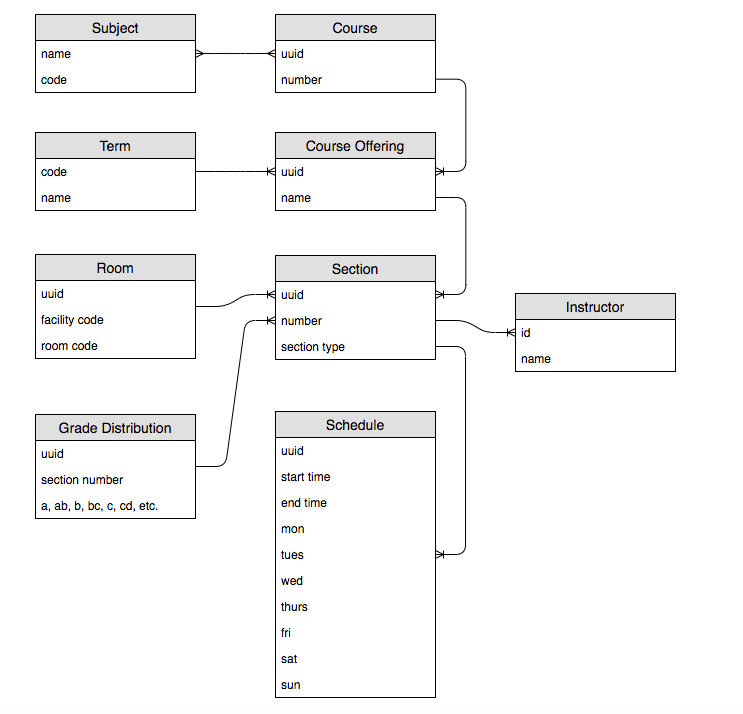

In [5]:
c.execute('PRAGMA table_info(sections)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'course_offering_uuid', 'TEXT', 0, None, 0),
 (2, 'section_type', 'TEXT', 0, None, 0),
 (3, 'number', 'TEXT', 0, None, 0),
 (4, 'room_uuid', 'TEXT', 0, None, 0),
 (5, 'schedule_uuid', 'TEXT', 0, None, 0)]

In [6]:
c.execute('PRAGMA table_info(schedules)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'start_time', 'TEXT', 0, None, 0),
 (2, 'end_time', 'TEXT', 0, None, 0),
 (3, 'mon', 'TEXT', 0, None, 0),
 (4, 'tues', 'TEXT', 0, None, 0),
 (5, 'wed', 'TEXT', 0, None, 0),
 (6, 'thurs', 'TEXT', 0, None, 0),
 (7, 'fri', 'TEXT', 0, None, 0),
 (8, 'sat', 'TEXT', 0, None, 0),
 (9, 'sun', 'TEXT', 0, None, 0)]

In [7]:
c.execute('PRAGMA table_info(grade_distributions)').fetchall()

[]

In [8]:
df = pd.DataFrame(c.execute("""
SELECT * FROM grade_dist AS gd, course_offerings AS co
WHERE co.uuid = gd.course_offering_uuid;""").fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,...,n_count,p_count,i_count,nw_count,nr_count,other_count,uuid,course_uuid,term_code,name
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,0,...,0,0,0,0,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,0,...,0,0,1,0,0,0,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,0,...,0,0,0,0,0,0,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,0,...,0,0,1,0,0,0,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,Cooperative Education Prog
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,Cooperative Education Prog


## Calculate class grade point average (GPA)

In [9]:
df.columns #grade columns

Index(['course_offering_uuid', 'section_number', 'a_count', 'ab_count',
       'b_count', 'bc_count', 'c_count', 'd_count', 'f_count', 's_count',
       'u_count', 'cr_count', 'n_count', 'p_count', 'i_count', 'nw_count',
       'nr_count', 'other_count', 'uuid', 'course_uuid', 'term_code', 'name'],
      dtype='object')

In [10]:
#Class grade counts were saved as text, converted to numbers
df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count', 'u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count', 'b_count', 'nr_count']] = df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count','u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count',
       'b_count', 'nr_count']].astype(int)
    

In [11]:
grade_df = df

In [12]:
#eliminated non-graded class scores, such as satisfactory, unsatisfactory, progress, other, 
#incomplete, etc. Data frame only includes classes with traditional grades. Included course 
#offering uuid and other class identifiers

grade_df.drop(['s_count','u_count', 'cr_count', 'n_count', 'p_count', 'i_count', 'nr_count', 'other_count'], axis = 1)

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,nw_count,uuid,course_uuid,term_code,name
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,0,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,0,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,0,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,Cooperative Education Prog
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,0,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,Cooperative Education Prog
5,87966a7b-f676-33d0-83d2-acdb67da6790,1,79,0,0,0,0,0,0,0,87966a7b-f676-33d0-83d2-acdb67da6790,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1112,Cooperative Education Prog
6,ff511882-5eab-3e7b-a89f-8fbfd1906127,1,114,3,1,0,0,0,0,0,ff511882-5eab-3e7b-a89f-8fbfd1906127,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1134,Cooperative Education Prog
7,b3e26604-fe6e-30df-bc91-b5fa57717a7e,1,105,1,0,0,0,0,1,0,b3e26604-fe6e-30df-bc91-b5fa57717a7e,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1084,Cooperative Education Prog
8,e100d196-5e82-32e4-80e9-ac45c07a498c,1,107,3,1,0,0,0,0,0,e100d196-5e82-32e4-80e9-ac45c07a498c,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1154,Cooperative Education Prog
9,76b9c458-d3c2-38c4-951f-69b6900bd7fe,1,129,8,2,0,1,1,0,0,76b9c458-d3c2-38c4-951f-69b6900bd7fe,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1162,Cooperative Education Prog


In [13]:
#calculated a class sum score. Multiplied grade count by score assigned by registrar.
grade_df['cum_grade'] = (grade_df['a_count'] * 4) + (grade_df['ab_count'] * 3.5) +\
            (grade_df['b_count'] * 3.0) + (grade_df['bc_count'] * 2.5) + (grade_df['c_count'] * 2.0) +\
            (grade_df['d_count'] * 1) + (grade_df['f_count'] * 0)

In [14]:
#calculated each class's enrollment by adding up each class count. nw_count is "no work" and the registrar
#notes that this is often should be recorded as a "F". It is included in enrollment sum.
grade_df['enrollment'] = grade_df[['c_count', 'nw_count', 'f_count', 'bc_count', 'd_count', 'ab_count', 
            'a_count', 'b_count']].sum(axis = 1)


In [15]:
#calculate class GPA
grade_df['class_gpa'] = grade_df['cum_grade']/grade_df['enrollment']

In [16]:
#calculate weighted class GPA to account for difference in different class sizes
grade_df['weighted_gpa'] = grade_df['cum_grade'] / (grade_df['enrollment']**2)

In [17]:
grade_df.head()

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,...,nr_count,other_count,uuid,course_uuid,term_code,name,cum_grade,enrollment,class_gpa,weighted_gpa
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,0,...,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,420.0,105,4.000000,0.038095
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,0,...,0,0,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog,632.0,158,4.000000,0.025316
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,0,...,0,0,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog,610.0,156,3.910256,0.025066
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,0,...,0,0,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,Cooperative Education Prog,348.0,87,4.000000,0.045977
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,0,...,0,0,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,Cooperative Education Prog,280.0,70,4.000000,0.057143


## Questions to explore

We decided to explore four questions:

1. Is there a different grade distribution in STEM classes than in traditional Liberal Arts classes?
2. Is there a different grade distribution in large classes than in small classes?
3. Is there a different grade distribution in morning classes than in afternoon classes?
4. Has there been grade inflation over the decade of the data set?

The first three questions are very similar in how they are structured and there are functions to do much of the analysis.  

## Exploratory Data Analysis of Question 1: Do STEM majors have a different grade distribution than Liberal Arts majors

In [18]:
#subjects include the name of the subject generally that maps to majors by code. They are not
#organized by School of Medicine, School of Engineering, etc.
c.execute("""
SELECT * FROM subjects;""").fetchall()

[('908', 'Soil Science', 'SOIL SCI'),
 ('350', 'ENGLISH', 'ENGLISH'),
 ('351', 'English as a Second Language', 'ESL'),
 ('230', 'Human Development and Family Studies', 'HDFS'),
 ('352', 'English', 'ENGL'),
 ('231', 'General Business', 'GEN BUS'),
 ('232', 'Accounting and Information Systems', 'ACCT I S'),
 ('112', 'Biological Systems Engineering', 'BSE'),
 ('233', 'Finance, Investment and Banking', 'FINANCE'),
 ('476', 'Horticulture', 'HORT'),
 ('355', 'Entomology', 'ENTOM'),
 ('234', 'Information Systems', 'INFO SYS'),
 ('235', 'International Business', 'INTL BUS'),
 ('236', 'Management and Human Resources', 'M H R'),
 ('237', 'Marketing', 'MARKETNG'),
 ('359', 'Design Studies', 'DS'),
 ('238', 'Operations and Technology Management', 'OTM'),
 ('239', 'Real Estate and Urban Land Economics', 'REAL EST'),
 ('912', 'Spanish (Spanish and Portuguese)', 'SPANISH'),
 ('480', 'Human Oncology', 'H ONCOL'),
 ('360', 'Environmental Studies - Gaylord Nelson Institute', 'ENVIR ST'),
 ('240', 'Civil

In [19]:
df_subjects = pd.DataFrame(c.execute("""
SELECT * FROM subjects ;""").fetchall())
df_subjects.columns = [i[0] for i in c.description]
df_subjects.head()

,code,name,abbreviation
0,908,Soil Science,SOIL SCI
1,350,ENGLISH,ENGLISH
2,351,English as a Second Language,ESL
3,230,Human Development and Family Studies,HDFS
4,352,English,ENGL


There are 200 majors that are not arranged in any order and often have similar names which most likely reflects that majors name changes over the decade. "English" is both upper case and title case. A new variable was added and added to the table assigning each major a STEM or Liberal Arts (LIB_ARTS) label. The assignment was based on the list of STEM majors that the National Science Foundation uses and the Department of Homeland Security uses for H-1B visas that STEM-eligible degrees. Majors that appeared on either list were given the STEM label. Medical related majors are not included in STEM designations. (https://en.wikipedia.org/wiki/Science,_technology,_engineering,_and_mathematics)

In [20]:
#focus label was added
df_focus = pd.DataFrame(c.execute("""
SELECT * FROM focus;""").fetchall())
df_focus.columns = [i[0] for i in c.description]
df_focus.head()

,Index,Code,Name,Abbreviation,Focus
0,1,908,Soil Science,SOIL SCI,STEM
1,2,350,ENGLISH,ENGLISH,LIB_ARTS
2,3,351,English as a Second Language,ESL,LIB_ARTS
3,4,230,Human Development and Family Studies,HDFS,LIB_ARTS
4,5,352,English,ENGL,LIB_ARTS


In [21]:
#course_offering_uuid is the primary key
df_sub_memb = pd.DataFrame(c.execute("""
SELECT * FROM subject_memberships;""").fetchall())
df_sub_memb.columns = [i[0] for i in c.description]
df_sub_memb.head()

,subject_code,course_offering_uuid
0,220,344b3ebe-da7e-314c-83ed-9425269695fd
1,320,344b3ebe-da7e-314c-83ed-9425269695fd
2,346,344b3ebe-da7e-314c-83ed-9425269695fd
3,612,344b3ebe-da7e-314c-83ed-9425269695fd
4,636,344b3ebe-da7e-314c-83ed-9425269695fd


In [22]:
#Create a pandas data frame and join the focus table code and grades with the course offering uuid
sql_str= ("""
SELECT * FROM subject_memberships
LEFT JOIN focus
ON subject_memberships.subject_code = focus.Code
LEFT JOIN course_offerings AS co
ON co.uuid = subject_memberships.course_offering_uuid
LEFT JOIN schedules
ON schedules.uuid = co.uuid
;""")

df_class_focus = pd.DataFrame(c.execute(sql_str).fetchall())
df_class_focus.columns = [i[0] for i in c.description]
df_class_focus.tail()

,subject_code,course_offering_uuid,Index,Code,Name,Abbreviation,Focus,uuid,course_uuid,term_code,...,uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun
95309,360,3573e335-e7be-33a6-b023-8704b3acc93b,21,360,Environmental Studies - Gaylord Nelson Institute,ENVIR ST,LIB_ARTS,3573e335-e7be-33a6-b023-8704b3acc93b,4a7f3d9d-f2e5-3df2-8dee-2c2d02ed9098,1182,...,None,None,None,None,None,None,None,None,None,None
95310,936,5d437083-a1d0-38b8-aa70-ec3564da39a6,47,936,Surgery,SURGERY,LIB_ARTS,5d437083-a1d0-38b8-aa70-ec3564da39a6,1220244c-2bbf-3169-8eb0-6a2da36f40f6,1182,...,None,None,None,None,None,None,None,None,None,None
95311,936,13278922-0726-3823-abda-dc14df03d8a6,47,936,Surgery,SURGERY,LIB_ARTS,13278922-0726-3823-abda-dc14df03d8a6,516f637c-a244-3df0-ba3f-f11ce650543d,1182,...,None,None,None,None,None,None,None,None,None,None
95312,936,fd039fe4-32ec-31dd-a142-c7db54df784b,47,936,Surgery,SURGERY,LIB_ARTS,fd039fe4-32ec-31dd-a142-c7db54df784b,fbe0838f-9469-3d83-ad85-91ba5aabd1a3,1182,...,None,None,None,None,None,None,None,None,None,None
95313,330,4e151e41-fdfb-3176-a96a-bec0715492a3,182,330,Emergency Medicine,EMER MED,LIB_ARTS,4e151e41-fdfb-3176-a96a-bec0715492a3,1b17abd5-39f9-3a2c-8eda-a88bf1871221,1182,...,None,None,None,None,None,None,None,None,None,None


In [23]:
#Add the grade df to the class focus data frame
df_grade_and_focus = pd.merge(df_class_focus, grade_df, on = 'course_offering_uuid')
df_grade_and_focus.tail()

,subject_code,course_offering_uuid,Index,Code,Name,Abbreviation,Focus,uuid_x,course_uuid_x,term_code_x,...,nr_count,other_count,uuid_y,course_uuid_y,term_code_y,name_y,cum_grade,enrollment,class_gpa,weighted_gpa
211758,708,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,66,708,Pediatrics,PEDIAT,LIB_ARTS,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,1a7208fe-4c3d-363e-884d-709ff424cb8d,1182,...,0,0,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,1a7208fe-4c3d-363e-884d-709ff424cb8d,1182,Peds Nephrology,0.0,0,NaN,NaN
211759,708,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,66,708,Pediatrics,PEDIAT,LIB_ARTS,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,1a7208fe-4c3d-363e-884d-709ff424cb8d,1182,...,0,0,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,1a7208fe-4c3d-363e-884d-709ff424cb8d,1182,Peds Nephrology,0.0,0,NaN,NaN
211760,360,3573e335-e7be-33a6-b023-8704b3acc93b,21,360,Environmental Studies - Gaylord Nelson Institute,ENVIR ST,LIB_ARTS,3573e335-e7be-33a6-b023-8704b3acc93b,4a7f3d9d-f2e5-3df2-8dee-2c2d02ed9098,1182,...,0,0,3573e335-e7be-33a6-b023-8704b3acc93b,4a7f3d9d-f2e5-3df2-8dee-2c2d02ed9098,1182,Conservation Planning,96.5,25,3.86,0.1544
211761,936,13278922-0726-3823-abda-dc14df03d8a6,47,936,Surgery,SURGERY,LIB_ARTS,13278922-0726-3823-abda-dc14df03d8a6,516f637c-a244-3df0-ba3f-f11ce650543d,1182,...,0,0,13278922-0726-3823-abda-dc14df03d8a6,516f637c-a244-3df0-ba3f-f11ce650543d,1182,Patient Ed. as Advocacy Strat.,0.0,0,NaN,NaN
211762,936,fd039fe4-32ec-31dd-a142-c7db54df784b,47,936,Surgery,SURGERY,LIB_ARTS,fd039fe4-32ec-31dd-a142-c7db54df784b,fbe0838f-9469-3d83-ad85-91ba5aabd1a3,1182,...,0,0,fd039fe4-32ec-31dd-a142-c7db54df784b,fbe0838f-9469-3d83-ad85-91ba5aabd1a3,1182,Multid. Appr. to Colon Cancer,0.0,0,NaN,NaN


More than 100,000 or 52% of the classes offered do not have any grades. Grades are the metric this analysis is based on for enrollment and student engagement. Without grades, these classes are not useful to the analysis. The class with the most zero-grades is Research (13,074), and other research/thesis classes are at the top. The bottom lists more unique classes like Thai Poetry that appeal to only a few students. These classes were eliminated from the dataset.

In [24]:
grade_df['enrollment'].value_counts().head()

0     106016
6       3653
8       3486
13      3408
7       3400
Name: enrollment, dtype: int64

In [25]:
#eliminate classes without grades. 
df_grade_and_focus = df_grade_and_focus[df_grade_and_focus['class_gpa'].notnull()]
df_grade_and_focus.tail()

,subject_code,course_offering_uuid,Index,Code,Name,Abbreviation,Focus,uuid_x,course_uuid_x,term_code_x,...,nr_count,other_count,uuid_y,course_uuid_y,term_code_y,name_y,cum_grade,enrollment,class_gpa,weighted_gpa
211745,352,2e6b777d-0433-3536-9f97-f6065f6c2fe0,5,352,English,ENGL,LIB_ARTS,2e6b777d-0433-3536-9f97-f6065f6c2fe0,c00c4712-43a6-364d-9e0c-1e465d44985b,1182,...,0,0,2e6b777d-0433-3536-9f97-f6065f6c2fe0,c00c4712-43a6-364d-9e0c-1e465d44985b,1182,Sem-Interdisc Theatre Studies,28.0,7,4.000000,0.571429
211746,305,45112b5d-edee-3485-b228-4de7638abe59,156,305,Educational Leadership and Policy Analysis,ELPA,LIB_ARTS,45112b5d-edee-3485-b228-4de7638abe59,f9107775-c1ea-3337-8510-e26bd16e85d2,1182,...,0,0,45112b5d-edee-3485-b228-4de7638abe59,f9107775-c1ea-3337-8510-e26bd16e85d2,1182,Race Class & Ed Inequality,80.0,20,4.000000,0.200000
211747,305,f4e61a47-2de4-355a-89a5-0162ced1fca2,156,305,Educational Leadership and Policy Analysis,ELPA,LIB_ARTS,f4e61a47-2de4-355a-89a5-0162ced1fca2,f9ccf6e6-c53f-30f6-b994-2d3bd0787034,1182,...,0,0,f4e61a47-2de4-355a-89a5-0162ced1fca2,f9ccf6e6-c53f-30f6-b994-2d3bd0787034,1182,Diversity and Inequality,82.0,21,3.904762,0.185941
211756,104,a111d2d1-7bc0-3559-9f23-41ca1e51a47c,194,104,African Languages and Literature,AFRICAN,LIB_ARTS,a111d2d1-7bc0-3559-9f23-41ca1e51a47c,8c152692-d7e8-3409-8172-0c50a8768542,1182,...,0,0,a111d2d1-7bc0-3559-9f23-41ca1e51a47c,8c152692-d7e8-3409-8172-0c50a8768542,1182,Sem in ACS: Tpcs,32.5,9,3.611111,0.401235
211760,360,3573e335-e7be-33a6-b023-8704b3acc93b,21,360,Environmental Studies - Gaylord Nelson Institute,ENVIR ST,LIB_ARTS,3573e335-e7be-33a6-b023-8704b3acc93b,4a7f3d9d-f2e5-3df2-8dee-2c2d02ed9098,1182,...,0,0,3573e335-e7be-33a6-b023-8704b3acc93b,4a7f3d9d-f2e5-3df2-8dee-2c2d02ed9098,1182,Conservation Planning,96.5,25,3.860000,0.154400


Three of the questions involve dividing the dataset into two categories and then comparing the grade distributions to see if there are differences through visualizations and some basic metrics. To simplify this process, functions were written to do the repeated work.

In [26]:
#divide data frame into two different categories by heading and value for comparison
def divide_df (each_df, heading, first_var, second_var):
    first_cat = each_df[each_df[heading] == first_var]
    second_cat = each_df[each_df[heading] == second_var]
    return first_cat, second_cat

In [27]:
df_first, df_second = divide_df(df_grade_and_focus, 'Focus', 'STEM', 'LIB_ARTS')

In [28]:
df_first.head()

,subject_code,course_offering_uuid,Index,Code,Name,Abbreviation,Focus,uuid_x,course_uuid_x,term_code_x,...,nr_count,other_count,uuid_y,course_uuid_y,term_code_y,name_y,cum_grade,enrollment,class_gpa,weighted_gpa
0,220,344b3ebe-da7e-314c-83ed-9425269695fd,189,220,Chemical and Biological Engineering,CBE,STEM,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,...,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,420.0,105,4.0,0.038095
1,320,344b3ebe-da7e-314c-83ed-9425269695fd,169,320,Electrical and Computer Engineering,E C E,STEM,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,...,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,420.0,105,4.0,0.038095
2,346,344b3ebe-da7e-314c-83ed-9425269695fd,193,346,Engineering Mechanics and Astronautics,E M A,STEM,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,...,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,420.0,105,4.0,0.038095
3,612,344b3ebe-da7e-314c-83ed-9425269695fd,92,612,Mechanical Engineering,M E,STEM,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,...,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,420.0,105,4.0,0.038095
4,636,344b3ebe-da7e-314c-83ed-9425269695fd,126,636,Materials Science and Engineering,M S & E,STEM,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,...,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,420.0,105,4.0,0.038095


In [29]:
df_second.head()

,subject_code,course_offering_uuid,Index,Code,Name,Abbreviation,Focus,uuid_x,course_uuid_x,term_code_x,...,nr_count,other_count,uuid_y,course_uuid_y,term_code_y,name_y,cum_grade,enrollment,class_gpa,weighted_gpa
235,741,a71789f0-09d9-3374-bd21-04a719a62af8,102,741,Dance,DANCE,LIB_ARTS,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,...,0,0,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,Workshop in Dance Activity,184.0,46,4.000000,0.086957
236,741,a71789f0-09d9-3374-bd21-04a719a62af8,102,741,Dance,DANCE,LIB_ARTS,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,...,0,0,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,Workshop in Dance Activity,164.0,41,4.000000,0.097561
237,741,a71789f0-09d9-3374-bd21-04a719a62af8,102,741,Dance,DANCE,LIB_ARTS,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,...,0,0,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,Workshop in Dance Activity,72.5,19,3.815789,0.200831
238,741,a71789f0-09d9-3374-bd21-04a719a62af8,102,741,Dance,DANCE,LIB_ARTS,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,...,0,0,a71789f0-09d9-3374-bd21-04a719a62af8,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,Workshop in Dance Activity,71.0,19,3.736842,0.196676
239,741,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,102,741,Dance,DANCE,LIB_ARTS,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,8f63bde1-ff7f-3fe7-9901-862908bf134c,1074,...,0,0,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,8f63bde1-ff7f-3fe7-9901-862908bf134c,1074,Workshop in Dance Activity,159.0,40,3.975000,0.099375


# Visualizations & Analysis

## Question 1: STEM and traditional liberal arts classes

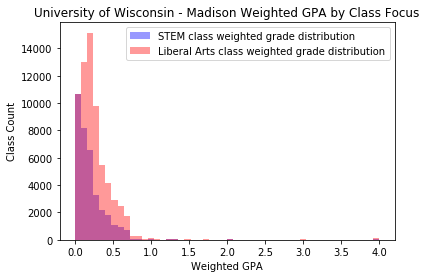

In [30]:
#STEM and Liberal Arts grade distributions curves are almost the same. The y axis is somewhat 
#different reflects the count of classes. There are 50,000 more liberal arts courses than STEM courses.
sns.distplot(df_first['weighted_gpa'], color = 'blue', kde = False, label = 'STEM class weighted grade distribution')
sns.distplot(df_second['weighted_gpa'], color = 'red', kde = False, label = 'Liberal Arts class weighted grade distribution')
plt.xlabel('Weighted GPA')
plt.ylabel('Class Count')
plt.title('University of Wisconsin - Madison Weighted GPA by Class Focus')
plt.legend()
plt.show()

## Question 2: Large and small classes

In [31]:
#The 75th distribution level for class size is 35 students.
df_grade_and_focus.describe()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,u_count,cr_count,n_count,p_count,i_count,nw_count,nr_count,other_count,cum_grade,enrollment,class_gpa,weighted_gpa
count,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000,102364.000000
mean,15.510766,7.806338,7.571900,2.668145,2.544264,0.688045,0.374810,0.473868,0.005637,0.000186,0.000156,0.001798,0.144680,0.035940,0.046989,0.018913,124.527881,37.200207,3.549137,0.240410
std,21.836437,12.777234,15.692374,7.163052,8.308128,2.646793,1.374093,2.515781,0.078808,0.023179,0.020255,0.105052,0.674292,0.306445,0.440627,0.156196,171.186678,54.452692,0.382371,0.251671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.500000,12.000000,3.289474,0.096886
50%,10.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000,19.000000,3.605263,0.187500
75%,17.000000,9.000000,7.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,121.000000,35.000000,3.888889,0.315972
max,704.000000,234.000000,219.000000,125.000000,157.000000,62.000000,37.000000,163.000000,3.000000,4.000000,4.000000,15.000000,51.000000,25.000000,34.000000,6.000000,2843.000000,716.000000,4.000000,4.000000


In [32]:
#The 75th distribution level for class size is 35 students.
df_large_class = df_grade_and_focus[df_grade_and_focus['enrollment'] > 35]
df_small_class = df_grade_and_focus[(df_grade_and_focus['enrollment'] <= 35) & (df_grade_and_focus['enrollment'] > 0)]

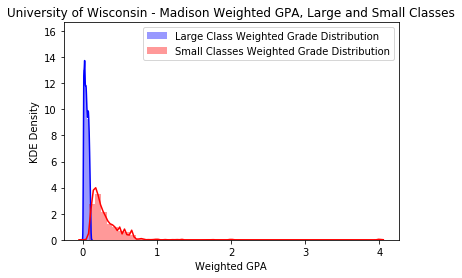

In [33]:
#Larger classes have signficantly different grade distribution than small classes.
sns.distplot(df_large_class['weighted_gpa'], color = 'blue', label = 'Large Class Weighted Grade Distribution')
sns.distplot(df_small_class['weighted_gpa'], color = 'red', label = 'Small Classes Weighted Grade Distribution')
plt.xlabel('Weighted GPA')
plt.ylabel('KDE Density')
plt.title('University of Wisconsin - Madison Weighted GPA, Large and Small Classes')
plt.legend()
plt.show()

In [34]:
ttest_ind(df_large_class['class_gpa'], df_small_class['class_gpa'], equal_var=False)

Ttest_indResult(statistic=-126.38008217977195, pvalue=0.0)

In [58]:
def t_calc(x, y):
    return (x.mean() - y.mean()) \
/  (len(x) *  np.std(x) + len(y) * np.std(y) \
/  (len(x)  +  len(y)  - 2))

In [60]:
df_2006 = df_year[df_year["year"] == 2006]
df_2017 = df_year[df_year["year"] == 2017]

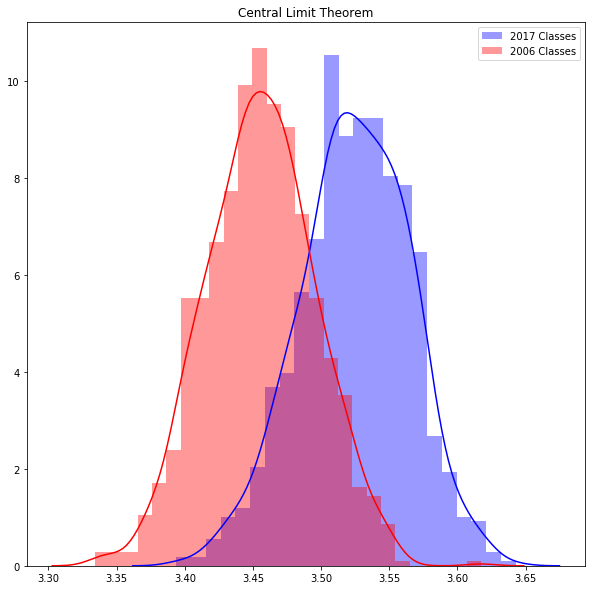

In [64]:
fig = plt.figure(figsize=(10,10))

large_samples = []
small_samples = []
for i in range(1000):
    sample1 = df_2006.sample(100)['class_gpa']
    small_samples.append(sample1.mean())
    
    sample2 = df_2017.sample(100)['class_gpa']
    large_samples.append(sample2.mean())

sns.distplot(large_samples, color="blue", label="2017 Classes")
sns.distplot(small_samples, color="red", label="2006 Classes")
plt.title('Central Limit Theorem')
plt.legend()

## Question 3: Morning and Afternoon Classes

There is some research and many stories about the best time for a class, student learning, attendance and enrollment. The day was divided at noon for morning and evening classes.

In [35]:
#A lot of classes do not have start times.
df_grade_and_focus['start_time'].isnull().count()

102364

In [36]:
# getting rid of some odd (n/a?) values for start time
df_grade_and_focus['start_time'] = df_grade_and_focus[df_grade_and_focus["start_time"] !=-1]

In [37]:
#start time was saved as text. Converted to a number
df_grade_and_focus["start_time"] = df_grade_and_focus["start_time"].astype(int)

In [38]:
# convert minutes to hours
df_grade_and_focus['start_time_hour'] = round(df_grade_and_focus["start_time"]/60,2)

In [39]:
# removing n/as
df_grade_and_focus = df_grade_and_focus[df_grade_and_focus["start_time_hour"].notna()]
df_grade_and_focus = df_grade_and_focus[df_grade_and_focus["weighted_gpa"].notna()]

In [40]:
# Early classes are defined as before noon, Late classes after that
df_early_class = df_grade_and_focus[df_grade_and_focus['start_time_hour'] >= 12]
df_late_class = df_grade_and_focus[(df_grade_and_focus['start_time_hour'] < 12) ]

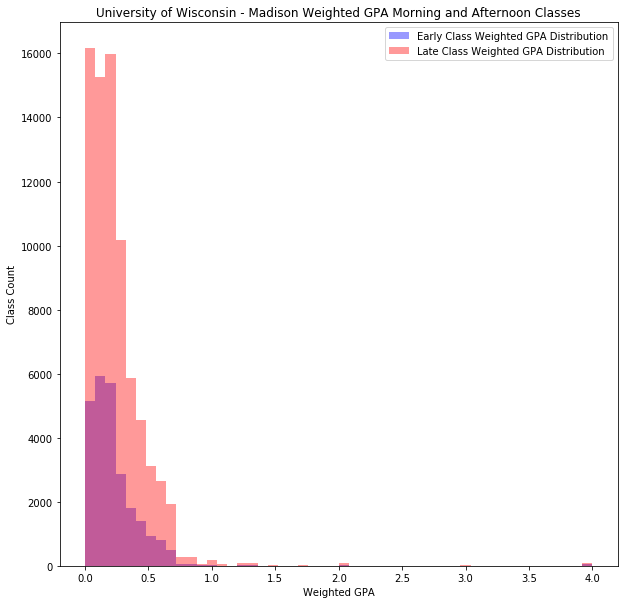

In [41]:
# Plot the distributions. They seem to map each other quite well
fig = plt.figure(figsize=(10,10))
plt.title("Distribution of GPAs, Early Classes vs. Late Classes")
sns.distplot(df_early_class['weighted_gpa'], color = 'blue', kde = False, label="Early Class Weighted GPA Distribution")
sns.distplot(df_late_class['weighted_gpa'], color = 'red', kde = False, label="Late Class Weighted GPA Distribution")
plt.xlabel('Weighted GPA')
plt.ylabel('Class Count')
plt.title('University of Wisconsin - Madison Weighted GPA Morning and Afternoon Classes')
plt.legend()
plt.show()

In [42]:
# T-statistic and p-value
ttest_ind(df_early_class['weighted_gpa'], df_late_class['weighted_gpa'], equal_var=False)

Ttest_indResult(statistic=-5.826542924987526, pvalue=5.70016892949964e-09)

## Question 4: Grade Distribution During the Past Decade

The fundamental question is: has there been grade inflation over the past decade at the University of Wisconsin, Madison. 

In [43]:
#The years associated with each term are in a separate dataset encoded and loaded.
df_terms = pd.read_csv('term_code - Sheet1.csv')

In [46]:
df_terms.to_sql('terms', conn)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


In [47]:
df = pd.DataFrame(c.execute("""
SELECT * FROM grade_dist AS gd, course_offerings AS co, terms

WHERE co.uuid = gd.course_offering_uuid
AND terms.`Term Number` = co.term_code

""").fetchall())
df.columns = [i[0] for i in c.description]
df.head()


,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,...,nw_count,nr_count,other_count,uuid,course_uuid,term_code,name,index,Calendar Year,Term Number
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,0,...,0,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,106,2008,1092
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,0,...,0,0,0,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog,105,2007,1082
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,0,...,0,0,0,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog,114,2016,1172
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,0,...,0,0,0,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,Cooperative Education Prog,10,2011,1114
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,0,...,0,0,0,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,Cooperative Education Prog,9,2010,1104


In [48]:
df["year"] = df["Calendar Year"]

In [54]:
df_year = pd.merge(df, df_grade_and_focus, left_on = 'course_uuid', right_on = 'course_uuid_y')

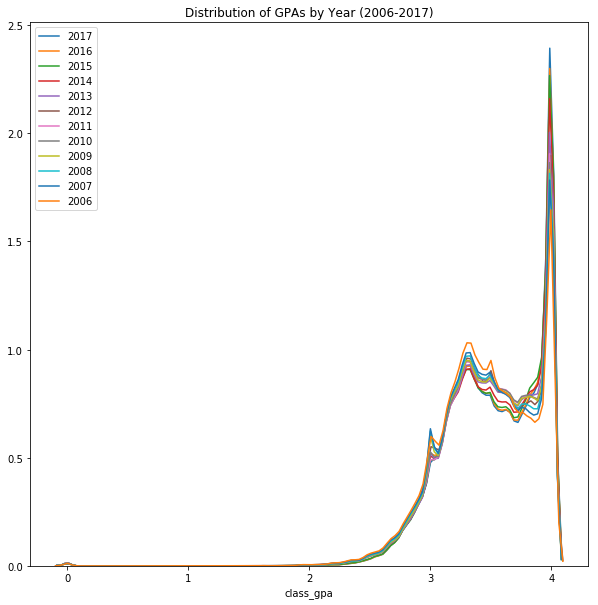

In [56]:
#Plot distribution of GPAs

fig = plt.figure(figsize=(10,10))
plt.title("Distribution of GPAs by Year (2006-2017)")
year_means = []

for y in sorted(df["year"].unique(), reverse=True):
    temp = df_year[df_year["year"] == y]
    sns.distplot(temp['class_gpa'], label=y, kde=True, hist=False)
    year_gpa = sum(temp["class_gpa"])/sum(temp["enrollment"])
    year_means.append([y, temp['class_gpa'].mean(), year_gpa])
plt.legend()